In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from src.tools import MMSeqs
from sklearn.metrics import r2_score, euclidean_distances
from src.dataset import Dataset
from src.graph import NeighborsGraph
import matplotlib as mpl
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import euclidean_distances
from src.embed.embedders.plm import ESMEmbedder
from src.files import FASTAFile
from src.classifier import Classifier
import itertools

from scipy.stats import mannwhitneyu
from sklearn.decomposition import PCA

%load_ext autoreload 
%autoreload 2


/home/prichter/miniconda3/envs/frugal/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [48]:
model_name = 'model_v2'
model = Classifier.load('../models/model_v2.pkl')

train_results_df = pd.read_csv('../data/results/dataset_train_predict.csv', index_col=0).assign(dataset='train')
test_results_df = pd.read_csv('../data/results/dataset_test_predict.csv', index_col=0).assign(dataset='test')

results_df = pd.concat([train_results_df, test_results_df])
results_df = results_df.rename(columns={f'{model_name}_output_0':'model_output_0', f'{model_name}_output_1':'model_output_1', f'{model_name}_label':'model_label'})[['model_label', 'model_output_0', 'model_output_1', 'dataset']].copy()

results_df = results_df.merge(pd.read_csv('../data/datasets/dataset.csv', index_col=0), left_index=True, right_index=True)

In [58]:
weird_products = list()
weird_products.append('DNA-directed RNA polymerase subunit omega')
weird_products.append('D-aminoacyl-tRNA deacylase')
# weird_products.append('leu operon leader peptide')
# weird_products.append('Leader peptide SpeFL')
weird_products.append('Putative membrane protein insertion efficiency factor')
weird_products.append('Quinohemoprotein amine dehydrogenase subunit gamma')

def get_summary(product:str, results_df:pd.DataFrame=results_df):
    summary = dict()
    results_df = results_df[results_df['product'] == product].copy()

    summary['product'] = product
    summary['n_spurious_95'] = (results_df.model_output_0 > 0.95).sum()
    summary['n_real_95'] = (results_df.model_output_1 > 0.95).sum()
    summary['n_hmm_hits'] = ((results_df.pfam_id != 'none') | (results_df.interpro_id != 'none')).sum()
    summary['total'] = len(results_df)
    summary['train_dataset_total'] = (results_df.dataset == 'train').sum()
    summary['train_dataset_spurious'] = ((results_df.dataset == 'train') & (results_df.model_output_0 > 0.95)).sum()
    summary['min_length'] = results_df.seq.apply(len).min()
    summary['max_length'] = results_df.seq.apply(len).max()
    summary['std_length'] = results_df.seq.apply(len).std()
    summary['mean_length'] = results_df.seq.apply(len).mean()
    return summary

summary_df = pd.DataFrame([get_summary(product) for product in weird_products]).set_index('product')
summary_df

,n_spurious_95,n_real_95,n_hmm_hits,total,train_dataset_total,train_dataset_spurious,min_length,max_length,std_length,mean_length
product,,,,,,,,,,
DNA-directed RNA polymerase subunit omega,5,379,429,429,339,4,62,180,22.550900,91.123543
D-aminoacyl-tRNA deacylase,4,370,396,396,320,3,141,261,7.003973,148.507576
Putative membrane protein insertion efficiency factor,11,229,369,369,311,9,66,152,15.645416,87.940379
Quinohemoprotein amine dehydrogenase subunit gamma,1,1,2,2,2,1,79,82,2.121320,80.500000


In [70]:
palette = dict()
palette['DNA-directed RNA polymerase subunit omega'] = 'indianred'
palette['D-aminoacyl-tRNA deacylase'] = 'plum'
palette['Putative membrane protein insertion efficiency factor'] = 'darkseagreen'
palette['Quinohemoprotein amine dehydrogenase subunit gamma'] = 'steelblue'

In [ ]:
# def figure(results_df:pd.DataFrame, products:list=weird_products):
#     fig, ax = plt.subplots(figsize=(10, 5))
#     for product in products:
#         ax_df = results_df[results_df['product'] == product].copy()
#         ax_df = ax_df[['model_output_0', 'seq']]
#         ax_df['length'] = ax_df.seq.apply(len)
#         sns.scatterplot(data=ax_df, color=palette[product], ax=ax, x='length', y='model_output_0', label=product)
#     ax.legend(loc='upper right')
#     ax.set_xlim(xmax=180, xmin=60)
#     plt.show()

# figure(results_df)

In [ ]:
def get_amino_acid_composition(df:pd.DataFrame, reduce:bool=False):
    df = df.copy()
    amino_acids = sorted(list('ACDEFGHIKLMNPQRSTVWY'))  
    # if reduce:
    #     df, amino_acids = get_reduced_sequences(df)
        
    aa_comp_df = [{aa:seq.count(aa) / len(seq) for aa in list(amino_acids)} for seq in df.seq]
    aa_comp_df = pd.DataFrame(aa_comp_df, index=df.index)[amino_acids]
    return aa_comp_df, amino_acids

In [75]:
def get_mutations(seq:str, n:int=2, mutations:dict=None, id_:str='B1Y0M2'):

    def mutate(seq:str, mutations:list):
        '''Apply a list of mutations, defined by (position, amino_acid), to the sequence.'''
        for position, amino_acid in mutations:
            seq = seq[:position] + amino_acid + seq[position + 1:]
        return seq
    
    seqs, ids = list(), list()
    # Generate every combination of n positions. 
    for positions in itertools.combinations(mutations.keys(), n):
        mutations_subset = {position:mutations[position] for position in positions} # Get a subset of the mutations corresponding to the selected positions. 
        mutations_subset = [[(position, amino_acid) for amino_acid in amino_acids] for position, amino_acids in mutations_subset.items()]
        # Select one mutation for each position being mutated, in every possible combination (the Cartesian product.). 
        for mutations_ in itertools.product(*mutations_subset):
            mutation_id = f'{id_}_' + '_'.join([f'{position}{amino_acid}' for position, amino_acid in sorted(mutations_, key=lambda m : m[0])])
            ids.append(mutation_id)
            seqs.append(mutate(seq, mutations_))
    return pd.DataFrame({'seq':seqs, 'id':ids}).set_index('id')

In [ ]:
def plot_pca(df:pd.DataFrame, ax:plt.Axes=None, color_by:pd.Series=None, palette=None, labels:list=list()):
    scaler = StandardScaler()
    components = scaler.fit_transform(df.values)

    pca = PCA(n_components=2)
    ax_df = pd.DataFrame(pca.fit_transform(components), index=df.index)
    ax_df[color_by.name] = ax_df.index.map(color_by)
    ax_df = ax_df.sort_values(color_by.name)

    var_0, var_1 = np.round(pca.explained_variance_ratio_ * 100, 2)

    if palette is None: # Use the custom green-to-red color map if no palette is specified.
        palette = mpl.colors.LinearSegmentedColormap.from_list('palette', ['darkseagreen', 'white', 'indianred'])
    sns.scatterplot(data=ax_df, x=0, y=1, hue=color_by.name, palette=palette, ax=ax)
    
    ax.set_ylabel(f'pca_1 ({var_1}%)')
    ax.set_xlabel(f'pca_0 ({var_0}%)')

    for label in labels:
        x, y = ax_df.loc[label][0], ax_df.loc[label][1]
        ax.text(x, y, label)
        
    ax.legend()

    return ax_df

In [7]:
def figure_1(results_df:pd.DataFrame, spurious_ids:list=None, ref_ids:list=None):
    
    fig, (ax_a, ax_b) = plt.subplots(figsize=(15, 5), width_ratios=[2/3, 1/3], ncols=2)

    ax_df, amino_acids = get_amino_acid_composition(results_df, reduce=False)
    ax_df['model_output_0'] = ax_df.index.map(results_df.model_output_0)
    ax_df = ax_df.sort_values('model_output_0')

    cmap = mpl.colors.LinearSegmentedColormap.from_list('palette', ['darkseagreen', 'white', 'indianred'])

    def mann_whitney_test(*groups, n_permutations:int=1000):
        '''Use a permutation test to determine the significance of the Mann-Whitney test statistic.'''
        n = len(groups[0])
        combined = np.concatenate(list(groups)).ravel()
        stat = mannwhitneyu(*groups, alternative='two-sided').statistic
        stats = list()
        for _ in range(n_permutations):
            np.random.shuffle(combined)
            stats.append(mannwhitneyu(combined[:n], combined[n:], alternative='two-sided').statistic)
        p = np.mean(np.array(stats) > stat)
        return p

    for i, aa in enumerate(amino_acids): # Don't think I can or should assume normality, so probably best to use Mann-Whitney
        p = mann_whitney_test(ax_df.loc[spurious_ids][aa].values, ax_df.loc[ref_ids][aa].values)
        if (p < 0.05):
            amino_acids[i] = amino_acids[i] + '*'

    ax_a.set_xticks(np.arange(len(amino_acids)), labels=amino_acids)
    sns.stripplot(data=ax_df.drop(columns='model_output_0'), ax=ax_a, c=ax_df.model_output_0, cmap=cmap)
    sns.pointplot(data=ax_df.drop(columns='model_output_0'), ax=ax_a, c='black', linestyle='none', err_kws={'linewidth':0.8}, capsize=0.2, zorder=10, markersize=1)
    ax_a.set_ylim(ymax=0.21, ymin=0)


    sns.kdeplot(x=results_df.seq.apply(len), label='all RpoZ', color='lightgray', ax=ax_b)
    sns.kdeplot(x=results_df[results_df.model_output_1 > 0.95].seq.apply(len), label='reference RpoZ', color='darkseagreen', ax=ax_b)
    ax_b.vlines(results_df.loc[spurious_ids].seq.apply(len), ymin=0, ymax=ax_b.get_ylim()[-1], color='indianred', ls=':')
    ax_b.set_xlabel('length')
    ax_b.set_ylabel('density')
    ax_b.legend()

    fig.tight_layout()
    plt.show()

In [21]:
def get_alignments(align_df:pd.DataFrame, id_:str, ref_ids:list=None, min_bit_score:float=None, same_length_only:bool=True):
    assert np.all(np.sort(align_df.query_id.unique()) == np.sort(align_df.subject_id.unique())), 'get_alignments: Expected symmetrical alignments.'
    align_df = align_df[(align_df.query_id == id_)].copy()
    if ref_ids is not None:
        align_df = align_df[align_df.subject_id.isin(list(ref_ids) + [id_])].copy() # Include the self-alignment for MSAs.
    if min_bit_score is not None:
        align_df = align_df[align_df.bit_score > min_bit_score].copy()
    if same_length_only: # Only include query-subject pairs that are the same length. 
        align_df = align_df[align_df.query_seq.apply(len) == align_df.subject_seq.apply(len)].copy()
    return align_df.sort_values('bit_score', ascending=False)

def get_best_alignments(align_df:pd.DataFrame, ref_ids:list=None, metric:str='bit_score'):
    '''Get the highest-scoring hit to a high-confidence real sequence.'''
    n_query_ids = align_df.query_id.nunique()
    if ref_ids is not None:
        align_df = align_df[align_df.subject_id.isin(ref_ids)].copy()
    align_df = align_df[align_df.query_id != align_df.subject_id].copy() # Remove self-alignments. 
    align_df = align_df.sort_values(metric, ascending=False)
    align_df = align_df.drop_duplicates('query_id', keep='first')
    assert len(align_df) == n_query_ids, 'get_best_alignments: Not every sequence has a hit with a high-confidence real sequence.'
    return align_df.set_index('query_id')

## DNA-directed RNA polymerase subunit omega (RpoZ)

In [10]:
rpoz_results_df = results_df[results_df['product'] == 'DNA-directed RNA polymerase subunit omega'].copy()
rpoz_results_df.to_csv('../data/results/rpoz/rpoz.csv')
FASTAFile(df=rpoz_results_df).write('../data/results/rpoz/rpoz.faa')

rpoz_dataset = Dataset.from_hdf('../data/results/rpoz/rpoz.h5')

threshold = 0.95
rpoz_ref_ids = rpoz_results_df[rpoz_results_df.model_output_1 > threshold].index.values # Get IDs for sequences predicted real with a high probability. 
rpoz_spurious_ids = rpoz_results_df[rpoz_results_df.model_output_0 > threshold].index.values # Get IDs for sequences predicted spurious with a high probability. 
print(len(rpoz_ref_ids), f'RpoZ sequences predicted real with >{threshold} certainty.')

379 RpoZ sequences predicted real with >0.95 certainty.


In [12]:
# foldseek = Foldseek()
# rpoz_foldseek_align_df = foldseek.align('../data/results/rpoz/pdbs', query_name='rpoz', output_dir='../data/results/rpoz', sensitivity=10)
mmseqs = MMSeqs()
rpoz_align_df = mmseqs.align(rpoz_results_df, query_name='rpoz', output_dir='../data/results/rpoz', sensitivity=10)

rpoz_distance_df = get_distances(rpoz_dataset)

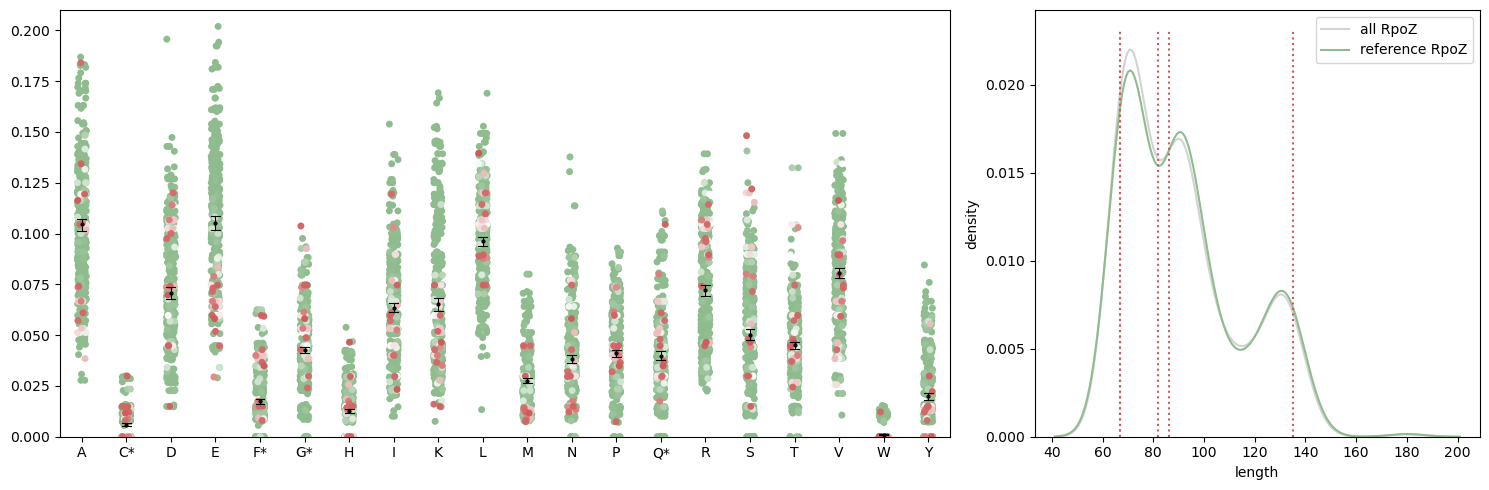

In [78]:
figure_1(rpoz_results_df, spurious_ids=rpoz_spurious_ids, ref_ids=rpoz_ref_ids)

get_matrix: Created matrix with shape (429, 429).
get_matrix: Created matrix with shape (429, 429).


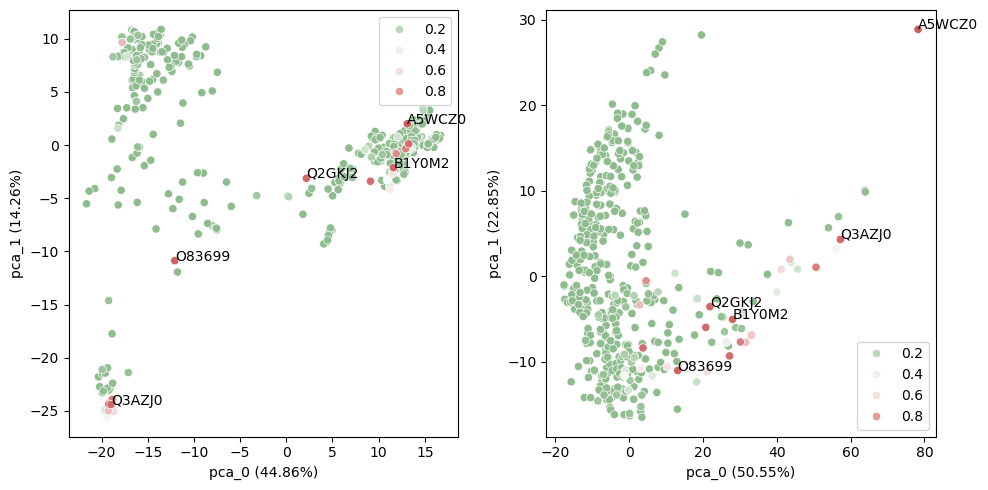

In [ ]:
fig, (ax_a, ax_b) = plt.subplots(figsize=(10, 5), ncols=2)
# ax_df = plot_pca(get_matrix(rpoz_foldseek_align_df, value_col='bit_score'), hue=rpoz_results_df.model_output_0, ax=ax_a, labels=list(rpoz_spurious_ids))
ax_df = plot_pca(get_matrix(rpoz_align_df, value_col='bit_score'), colors=rpoz_results_df.model_output_0, ax=ax_a, labels=list(rpoz_spurious_ids))
ax_df = plot_pca(get_matrix(rpoz_distance_df, value_col='distance'), colors=rpoz_results_df.model_output_0, ax=ax_b, labels=list(rpoz_spurious_ids))
fig.tight_layout()
plt.show()

In [13]:
b1y0m2_align_df = get_alignments(rpoz_align_df, id_='B1Y0M2', ref_ids=rpoz_ref_ids, min_bit_score=100).rename(columns={'subject_seq':'seq'}).set_index('subject_id')
a5wcz0_align_df = get_alignments(rpoz_align_df, id_='A5WCZ0', ref_ids=rpoz_ref_ids, min_bit_score=100).rename(columns={'subject_seq':'seq'}).set_index('subject_id')

FASTAFile(df=b1y0m2_align_df).write('../data/results/rpoz/b1y0m2.faa')
FASTAFile(df=a5wcz0_align_df).write('../data/results/rpoz/a5wcz0.faa')

# ! ~/muscle5.1.linux_intel64 -align '../data/results/rpoz/b1y0m2.faa' -output '../data/results/rpoz/b1y0m2.afa'
# ! ~/muscle5.1.linux_intel64 -align '../data/results/rpoz/a5wcz0.faa' -output '../data/results/rpoz/a5wcz0.afa'

In [79]:
# Mutate all K values at position 62 to an R. 

b1y0m2_mutations = dict()
b1y0m2_mutations[5] = ['I']
b1y0m2_mutations[10] = ['E', 'K']
b1y0m2_mutations[11] = ['Q', 'H']
b1y0m2_mutations[17] = ['E']
b1y0m2_mutations[19] = ['T', 'A']
b1y0m2_mutations[21] = ['S', 'C']
b1y0m2_mutations[28] = ['Q']
b1y0m2_mutations[30] = ['L', 'A', 'V']
b1y0m2_mutations[34] = ['T']
b1y0m2_mutations[35] = ['A']
b1y0m2_mutations[36] = ['R']
b1y0m2_mutations[37] = ['I']
b1y0m2_mutations[38] = ['D']
b1y0m2_mutations[39] = ['S', 'A', 'C']
b1y0m2_mutations[40] = ['R']
b1y0m2_mutations[41] = ['D']
b1y0m2_mutations[44] = ['T', 'A']
b1y0m2_mutations[46] = ['I', 'V']
b1y0m2_mutations[53] = ['E', 'S']
b1y0m2_mutations[55] = ['K', 'H', 'Q', 'L']
b1y0m2_mutations[56] = ['I']
b1y0m2_mutations[58] = ['L', 'V']
b1y0m2_mutations[62] = ['K']
b1y0m2_mutations[66] = ['S', 'V', 'N', 'A', 'T']


b1y0m2_seq = 'MARITVEDCLQKIPNRFQLVLAATYRARMLSQGHAPKVETKNKPGVTALREIAAGAVGIEMLRKVPG'
b1y0m2_df = pd.concat([get_mutations(b1y0m2_seq, n=2, mutations=b1y0m2_mutations), get_mutations(b1y0m2_seq, n=1, mutations=b1y0m2_mutations)])

# embedder = ESMEmbedder(model_size='650m')
# b1y0m2_embeddings = embedder(b1y0m2_df.seq)
# b1y0m2_dataset = Dataset(embedding=b1y0m2_embeddings, index=b1y0m2_df.index)
# b1y0m2_dataset.to_hdf('../data/results/rpoz/b1y0m2.h5')

# b1y0m2_dataset = Dataset.from_hdf('../data/results/rpoz/b1y0m2.h5')
# model.scale(b1y0m2_dataset, fit=False)
# model_labels, model_outputs = model.predict(b1y0m2_dataset, include_outputs=True)
# b1y0m2_results_df = pd.DataFrame({'model_label':model_labels, 'model_output_0':model_outputs.T[0], 'model_output_1':model_outputs.T[1]}, index=b1y0m2_dataset.index)
# b1y0m2_results_df.to_csv('../data/results/rpoz/b1y0m2_results.csv')

b1y0m2_results_df = pd.read_csv('../data/results/rpoz/b1y0m2_results.csv', index_col=0)

len(b1y0m2_mutations)

24

In [67]:
b1y0m2_real_ids = b1y0m2_results_df[b1y0m2_results_df.model_label == 1].index
b1y0m2_dataset = Dataset.from_hdf('../data/results/rpoz/b1y0m2.h5')
b1y0m2_rpoz_dataset = rpoz_dataset.concat(b1y0m2_dataset.loc(b1y0m2_real_ids))
b1y0m2_rpoz_dist_df = get_distances(b1y0m2_rpoz_dataset)

Dataset.from_hdf: No metadata stored in the Dataset at ../data/results/rpoz/b1y0m2.h5


get_matrix: Created matrix with shape (500, 500).


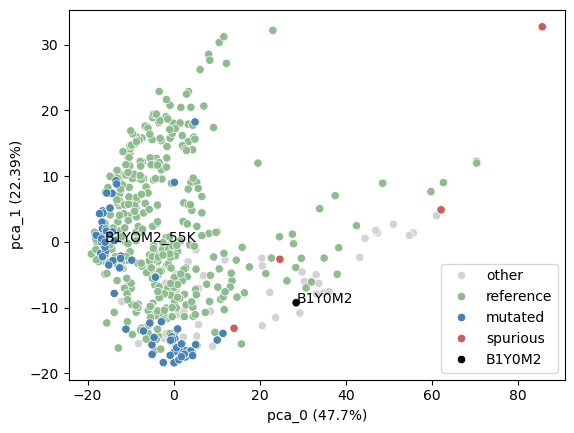

In [ ]:
fig, ax = plt.subplots(figsize=(5, 5))

palette = {'reference':'darkseagreen', 'mutated':'steelblue', 'spurious':'indianred', 'B1Y0M2':'black', 'other':'lightgray'}

ids = b1y0m2_rpoz_dataset.index
conditions = [np.isin(ids, rpoz_ref_ids), np.isin(ids, b1y0m2_df.index), (ids == 'B1Y0M2'), np.isin(ids, rpoz_spurious_ids)]
categories = np.select(conditions, ['reference', 'mutated', 'B1Y0M2', 'spurious'], default='other')
categories = pd.Categorical(categories, categories=['other', 'reference', 'mutated', 'spurious', 'B1Y0M2'], ordered=True)
categories = pd.Series(categories, name='category', index=ids)

ax_df = plot_pca(get_matrix(b1y0m2_rpoz_dist_df), color_by=categories, palette=palette, ax=ax, labels=['B1Y0M2', 'B1Y0M2_55K'])

plt.show()


In [ ]:
# b1y0m2_embeddings_df = pd.DataFrame(rpoz_dataset.numpy(), index=rpoz_dataset.index)
# b1y0m2_embeddings_df = b1y0m2_embeddings_df.loc[b1y0m2_df.index]

# n_components = 10
# scaler = StandardScaler()
# pca = PCA(n_components=10)

# components = pca.fit_transform(scaler.fit_transform(b1y0m2_embeddings_df.values))
# total_var = pca.explained_variance_ratio_.sum() * 100
# print(f'{n_components} components explains {total_var:.2f}% of the variance between homolog vector representations.')

# loadings_df = pd.DataFrame(np.abs(pca.components_.T))
# loadings_df = pd.DataFrame(np.argsort(np.abs(pca.components_.T), axis=0)).iloc[:-50]


10 components explains 95.56% of the variance between homolog vector representations.


## Putative membrane protein insertion efficiency factor (YidD)

In [15]:
yidd_results_df = results_df[results_df['product'] == 'Putative membrane protein insertion efficiency factor'].copy()
yidd_results_df.to_csv('../data/results/yidd/yidd.csv')
FASTAFile(df=yidd_results_df).write('../data/results/yidd/yidd.faa')

yidd_dataset = Dataset.from_hdf('../data/results/yidd/yidd.h5')

threshold = 0.95
yidd_ref_ids = yidd_results_df[yidd_results_df.model_output_1 > threshold].index.values # Get IDs for sequences predicted real with a high probability. 
yidd_spurious_ids = yidd_results_df[yidd_results_df.model_output_0 > threshold].index.values # Get IDs for sequences predicted spurious with a high probability. 
print(len(yidd_ref_ids), f'YidD sequences predicted real with >{threshold} certainty.')

229 YidD sequences predicted real with >0.95 certainty.


In [16]:
# foldseek = Foldseek()
# rpoz_foldseek_align_df = foldseek.align('../data/results/rpoz/pdbs', query_name='rpoz', output_dir='../data/results/rpoz', sensitivity=10)
mmseqs = MMSeqs()
yidd_align_df = mmseqs.align(yidd_results_df, query_name='yidd', output_dir='../data/results/yidd', sensitivity=10)

yidd_distance_df = get_distances(yidd_dataset)

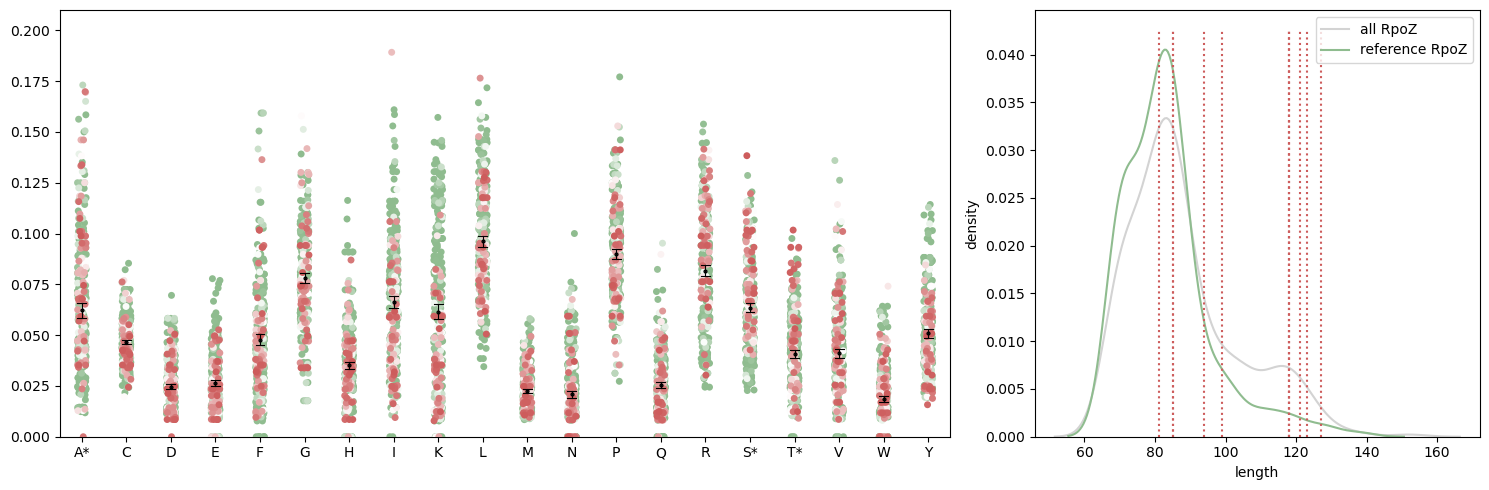

In [79]:
figure_1(yidd_results_df, spurious_ids=yidd_spurious_ids, ref_ids=yidd_ref_ids)

get_matrix: Created matrix with shape (369, 369).
get_matrix: Created matrix with shape (369, 369).


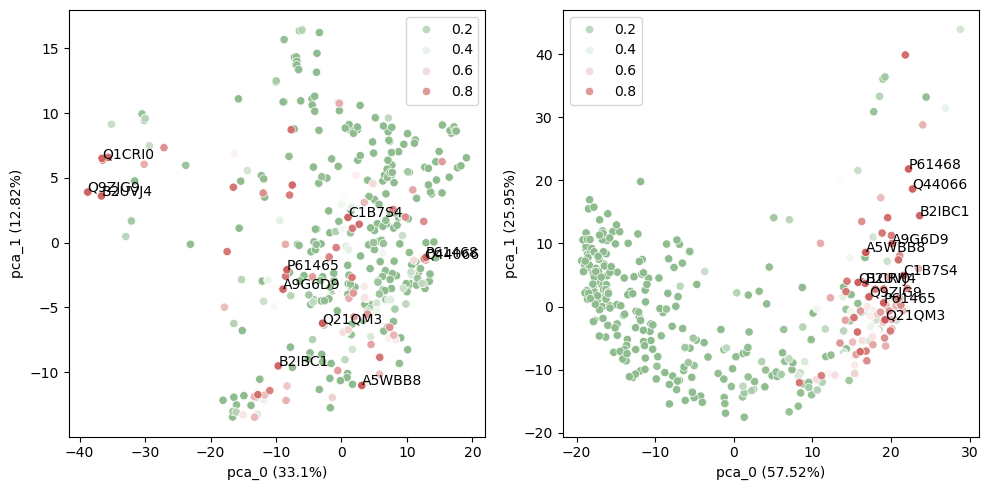

In [ ]:
fig, (ax_a, ax_b) = plt.subplots(figsize=(10, 5), ncols=2)
# ax_df = plot_pca(get_matrix(rpoz_foldseek_align_df, value_col='bit_score'), hue=rpoz_results_df.model_output_0, ax=ax_a, labels=list(rpoz_spurious_ids))
ax_df = plot_pca(get_matrix(yidd_align_df, value_col='bit_score'), color_by=yidd_results_df.model_output_0, ax=ax_a, labels=list(yidd_spurious_ids))
ax_df = plot_pca(get_matrix(yidd_distance_df, value_col='distance'), color_by=yidd_results_df.model_output_0, ax=ax_b, labels=list(yidd_spurious_ids))
fig.tight_layout()
plt.show()

In [29]:
q44066_df = get_alignments(yidd_align_df, 'Q44066', ref_ids=yidd_ref_ids, min_bit_score=100, same_length_only=True).rename(columns={'subject_seq':'seq'}).set_index('subject_id')
a5wbb8_df = get_alignments(yidd_align_df, 'A5WBB8', ref_ids=yidd_ref_ids, min_bit_score=100, same_length_only=True).rename(columns={'subject_seq':'seq'}).set_index('subject_id')
p61468_df = get_alignments(yidd_align_df, 'P61468', ref_ids=yidd_ref_ids, min_bit_score=100, same_length_only=True).rename(columns={'subject_seq':'seq'}).set_index('subject_id')
b2ibc1_df = get_alignments(yidd_align_df, 'B2IBC1', ref_ids=yidd_ref_ids, min_bit_score=100, same_length_only=True).rename(columns={'subject_seq':'seq'}).set_index('subject_id')

# Spurious sequences with near-perfect matches to reference sequences. 
# Q44066
# A5WBB8
# P61468
# B2IBC1

q44066_df

,query_id,e_value,bit_score,fraction_identical_matches,query_seq,seq,query_coverage,subject_coverage,n_mismatches,alignment_length
subject_id,,,,,,,,,,
Q44066,Q44066,4.645000e-58,185,1.000,MASALSPGSRVLIALIRVYQRLISPLLGPHCRFTPTCSSYGIEALR...,MASALSPGSRVLIALIRVYQRLISPLLGPHCRFTPTCSSYGIEALR...,1.000,1.000,0,85
P61467,Q44066,3.892000e-56,179,0.964,MASALSPGSRVLIALIRVYQRLISPLLGPHCRFTPTCSSYGIEALR...,MAPPLSPGSRALIALIRVYQRLISPLLGPHCRFTPTCSSYGIEALR...,1.000,1.000,3,85
A8G7P9,Q44066,7.219000e-45,147,0.776,MASALSPGSRVLIALIRVYQRLISPLLGPHCRFTPTCSSYGIEALR...,MASPLSPGSRILIGLVRAYQLVISPLLGPRCRFQPTCSHYAIEALS...,1.000,1.000,19,85
Q2NQ70,Q44066,1.866000e-44,146,0.764,MASALSPGSRVLIALIRVYQRLISPLLGPHCRFTPTCSSYGIEALR...,MAPPLSPVSKLLIGLIRGYQLVISPLLGPHCRFRPTCSQYGIEAIR...,1.000,1.000,20,85
Q1C0B5,Q44066,2.561000e-44,145,0.800,MASALSPGSRVLIALIRVYQRLISPLLGPHCRFTPTCSSYGIEALR...,MASPLSPGSRILIGLIRGYQLVISPLLGPRCRFHPTCSHYGIEALR...,1.000,1.000,17,85
Q9KVY3,Q44066,6.656000e-33,113,0.649,MASALSPGSRVLIALIRVYQRLISPLLGPHCRFTPTCSSYGIEALR...,MATPLSPFSWLAIGIVKLYQWFISPLIGPRCRFTPTCSTYAIEALR...,0.906,0.906,27,77
C4LDZ5,Q44066,4.094000e-31,108,0.657,MASALSPGSRVLIALIRVYQRLISPLLGPHCRFTPTCSSYGIEALR...,MAHPRTPQQRLAVALIRVYQWVISPLLGPRCRFTPTCSQYMINAIC...,0.894,0.894,26,76
Q1LTW0,Q44066,1.996000e-30,106,0.564,MASALSPGSRVLIALIRVYQRLISPLLGPHCRFTPTCSSYGIEALR...,MASLLSPIIKLLSYVIRCYQLIISPLIKPHCRFLPTCSQYSITAIH...,1.000,1.000,37,85
B7VGH8,Q44066,4.750000e-29,102,0.597,MASALSPGSRVLIALIRVYQRLISPLLGPHCRFTPTCSSYGIEALR...,MASPVSPFAWIALIPIYFYRWFISPLIGPRCRFTPTCSLYAIEALK...,0.906,0.906,31,77


In [40]:
# graph = NeighborsGraph.load('../data/datasets/dataset_graph.pkl')
# product_color_map = {'DNA-directed RNA polymerase subunit omega':'steelblue', 'DUF957 domain-containing protein':'powderblue', 'Nitrogenase-stabilizing/protective protein NifW':'pink', 'D-aminoacyl-tRNA deacylase':'plum', 'Uncharacterized protein':'gray', 'Large ribosomal subunit protein bL31B':'darkseagreen', 'Small ribosomal subunit protein uS19':'darkseagreen'}

# fig, (ax_a, ax_b) = plt.subplots(figsize=(20, 10), ncols=2)

# colors = {row.Index:product_color_map.get(getattr(row, 'product').strip(), 'lightgray') for row in results_df.itertuples()}
# colors.update({id_:'indianred' for id_ in results_df[results_df.label == 0].index})
# colors.update({id_:'black' for id_ in rpoz_spurious_ids})
# graph_subset = graph.draw(subset_ids=rpoz_results_df.index, colors=colors, labels=list(rpoz_spurious_ids), ax=ax_a)

# cmap = mpl.colors.LinearSegmentedColormap.from_list('steelblue_indianred', ['steelblue', 'white', 'indianred'])
# colors = {row.Index:cmap(row.model_output_0) for row in results_df.itertuples()}
# colors.update({id_:'black' for id_ in rpoz_spurious_ids})
# graph.draw(subset_ids=rpoz_results_df.index, colors=colors, labels=list(b1y0m2_msa_df.index), ax=ax_b)
# graph.draw(subset_ids=rpoz_results_df.index, colors=colors, labels=list(rpoz_spurious_ids), ax=ax_b)

# plt.show()

In [ ]:
# rpoz_interpro_df = InterProScanFile('../data/results/rpoz/rpoz_interpro.tsv').to_df()
# # rpoz_interpro_df = rpoz_interpro_df.sort_values('interpro_e_value')[~rpoz_interpro_df.index.duplicated()]
# rpoz_interpro_df = rpoz_interpro_df[~rpoz_interpro_df.interpro_analysis.isin(['MobiDBLite', 'Coils'])].copy()
# rpoz_interpro_df['model_output_0'] = rpoz_interpro_df.index.map(rpoz_results_df.model_output_0)
# rpoz_interpro_df['interpro_e_value'] = -np.log10(rpoz_interpro_df.interpro_e_value)
# # rpoz_interpro_df['interpro_bit_score'] = rpoz_interpro_df.interpro_bit_score
# rpoz_interpro_df['length'] = rpoz_results_df.seq.apply(len)

# sns.scatterplot(data=rpoz_interpro_df, x='interpro_e_value', y='model_output_0', hue='interpro_analysis')

In [ ]:

# def apply_reduced_alphabet(df:pd.DataFrame): 
#     # https://academic.oup.com/peds/article/16/5/323/1542677?login=true
#     reduced_alphabet = {'F':'Y', 'W':'Y', 'Y':'Y', 'M':'L', 'L':'L', 'I':'V', 'V':'V', 'C':'A', 'A':'A', 'T':'T', 'S':'T', 'N':'N', 'H':'N', 'P':'P', 'G':'G', 'D':'D', 'E':'D', 'Q':'K', 'R':'K', 'K':'K'}
#     # reduced_alphabet = {'F':'Y', 'W':'Y', 'Y':'Y', 'M':'I', 'L':'I', 'I':'I', 'V':'I', 'C':'S', 'A':'S', 'T':'S', 'S':'S', 'N':'E', 'H':'Y', 'P':'P', 'G':'G', 'D':'E', 'E':'E', 'Q':'E', 'R':'K', 'K':'K'}
#     amino_acids = list(set(reduced_alphabet.values()))
#     amino_acids = sorted(amino_acids) # Ensure consistent ordering. 

#     def reduce(seq:str):
#         for aa, rep_aa in reduced_alphabet.items():
#             seq = seq.replace(aa, rep_aa) # Replace each amino acid with its representative. 
#         return seq
    
#     df['seq'] = df.seq.apply(reduce)
#     return df, amino_acids


In [ ]:
# def figure(df:pd.DataFrame, results_df:pd.DataFrame, ref_ids:list=None, metric:str=None, ax:plt.Axes=None):
#     ax_df = get_best_alignments(df, ref_ids=ref_ids, metric=metric)
#     ax_df = ax_df[~ax_df.index.isin(ref_ids)]
#     ax_df['model_output_0'] = ax_df.index.map(results_df.model_output_0)

#     # sns.scatterplot(data=ax_a_df, x='sequence_identity', y='model_output_0', ax=ax_a)
#     sns.regplot(data=ax_df, x=metric, y='model_output_0', ax=ax)
#     r2 = r2_score(ax_df[metric], ax_df.model_output_0)
#     ax.text(0.75, 0.75, f'$r^2$={r2:.2f}', transform=ax.transAxes)
#     ax.set_ylim(ymax=1, ymin=0)

# fig, (ax_a , ax_b, ax_c) = plt.subplots(ncols=3, figsize=(15, 5))

# figure(rpoz_foldseek_align_df, rpoz_results_df, ref_ids=rpoz_ref_ids, metric='bit_score', ax=ax_a)
# figure(rpoz_align_df, rpoz_results_df, ref_ids=rpoz_ref_ids, metric='bit_score', ax=ax_b)
# figure(rpoz_distance_df, rpoz_results_df, ref_ids=rpoz_ref_ids, metric='similarity', ax=ax_c)
# plt.show()